<a href="https://colab.research.google.com/github/girijeshcse/autovision/blob/prasad/Prasad_CAP_STONE_CV2_Car_Detection_TFX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tfx

     |████████████████████████████████| 2.4 MB 4.9 MB/s 
     |████████████████████████████████| 40 kB 5.0 MB/s 
     |████████████████████████████████| 1.8 MB 43.2 MB/s 
     |████████████████████████████████| 98 kB 6.3 MB/s 
     |████████████████████████████████| 1.7 MB 54.8 MB/s 
     |████████████████████████████████| 422 kB 58.5 MB/s 
     |████████████████████████████████| 1.4 MB 56.4 MB/s 
     |████████████████████████████████| 19.1 MB 367 kB/s 
     |████████████████████████████████| 135 kB 59.1 MB/s 
     |████████████████████████████████| 6.6 MB 24.8 MB/s 
     |████████████████████████████████| 9.9 MB 40.0 MB/s 
     |████████████████████████████████| 205 kB 75.5 MB/s 
     |████████████████████████████████| 1.2 MB 61.5 MB/s 
     |████████████████████████████████| 1.7 MB 46.6 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 147 kB 60.7 MB/s 
     |████████████████████████████████| 151 kB 61.2 MB/s 
     |███████████████

In [2]:
!pip install tflite-support

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 210 kB 60.5 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


In [3]:
!pip install utils
!pip install python-utils

In [1]:
import os
import tfx
from typing import Optional, Text, List
from absl import logging
from ml_metadata.proto import metadata_store_pb2
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.local.local_dag_runner import LocalDagRunner

from tfx.types import Channel

from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.proto import example_gen_pb2

from tfx.dsl.components.base import executor_spec

from tfx.components.trainer import executor as trainer_executor
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import ImportExampleGen
from tfx.components import CsvExampleGen

# from tfx.components import Pusher
# from tfx.components import ResolverNode
from tfx.components import Transform

# from tfx.components import Evaluator

import tensorflow as tf
import pandas     as pd

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip
import warnings
import cv2
warnings.filterwarnings('ignore')

In [2]:
print("TensorFlow version :{}".format(tf.__version__))
print("TFX version :{}".format(tfx.__version__))

TensorFlow version :2.7.0
TFX version :1.5.0


In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
base='/content/drive/MyDrive/AIML/CapStone'
os.chdir(base)

# Pre Procesing

In [ ]:
df = pd.read_csv('Car names and make.csv', header=None,names =['names'])
df['year'] = df['names'].str[-4:]
df['names'] = df['names'].apply(lambda x:x[:-4])
df

,names,year
0,AM General Hummer SUV,2000
1,Acura RL Sedan,2012
2,Acura TL Sedan,2012
3,Acura TL Type-S,2008
4,Acura TSX Sedan,2012
...,...,...
191,Volkswagen Beetle Hatchback,2012
192,Volvo C30 Hatchback,2012
193,Volvo 240 Sedan,1993
194,Volvo XC90 SUV,2007


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   196 non-null    object
 1   year    196 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


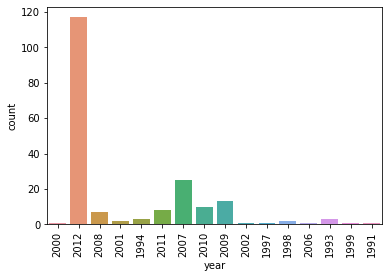

In [ ]:
sns.countplot(x='year',data=df)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
text = " ".join(name for name in df.names)
print ("There are {} words in the combination of all records.".format(len(text)))

There are 4669 words in the combination of all records.


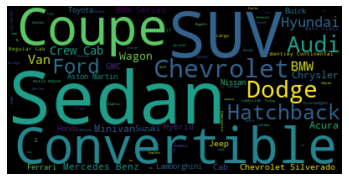

In [ ]:
from wordcloud import WordCloud
# Generate a word cloud image
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

can observe dataset has more of Sedan , SUV and Coupe brand type cars

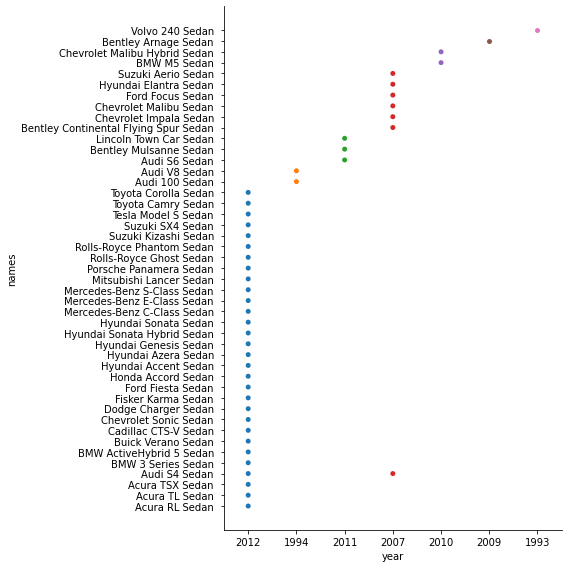

In [ ]:
# filtering the rows for Sedan
df1=df[df['names'].str.contains('Sedan')]
sns.catplot(y="names", x="year", data=df1,kind="swarm",height=8, aspect=1)

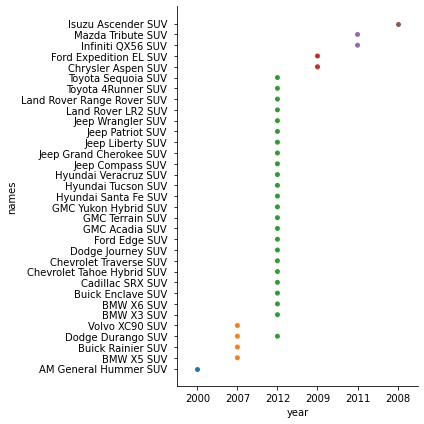

In [ ]:
# filtering the rows for Sedan
df2=df[df['names'].str.contains('SUV')]
sns.catplot(y="names", x="year", data=df2,kind="swarm",height=6, aspect=1)

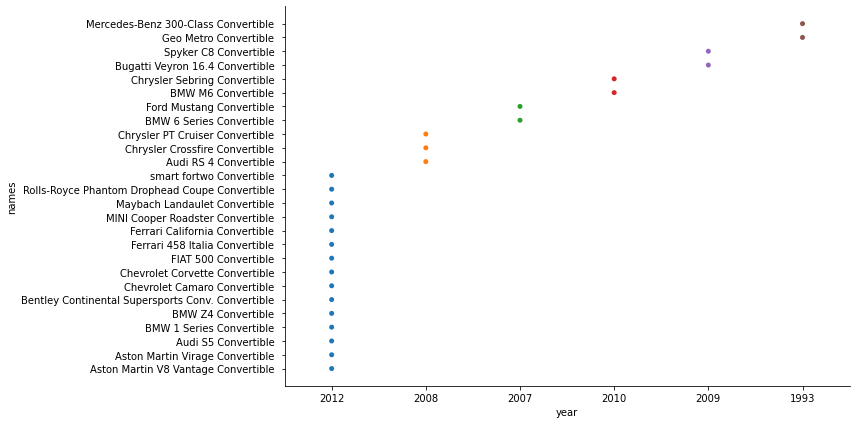

In [ ]:
# filtering the rows for Sedan
df3=df[df['names'].str.contains('Convertible')]
sns.catplot(y="names", x="year", data=df3,kind="swarm",height=6, aspect=2)

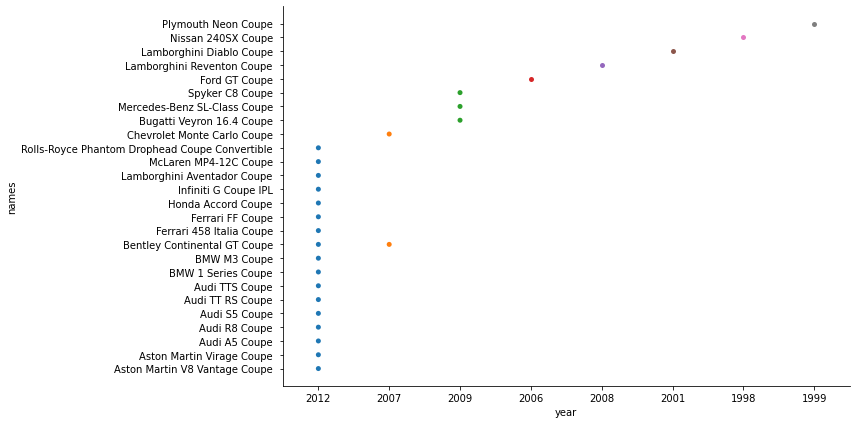

In [ ]:
# filtering the rows for Sedan
df4=df[df['names'].str.contains('Coupe')]
sns.catplot(y="names", x="year", data=df4,kind="swarm",height=6, aspect=2)

In [ ]:
def get_image_details(path):
    data = pd.DataFrame()
    base_path = os.path.join(base,path)

    # list all folders inside train directory
    for dname in os.listdir(base_path):   
      dir_path = os.path.join(base_path, dname)  
      # if it's a directory
      if os.path.isdir(dir_path):
        for fname in os.listdir(dir_path):
          # is it a valid file (ends with .jpg)
            if fname.endswith('.jpg'): 
              fpath = os.path.join(dir_path, fname)

            # read each image inside train directory one by one
              img = cv2.imread(fpath)
              sdpath = os.path.join(dname,fname)
              temp_df = pd.DataFrame({'filepath':[fpath],'filename' : [sdpath],'imgname':[fname],'height': [img.shape[0]],'width' : [img.shape[1]],'class' : [dname] })
              data = data.append(temp_df, ignore_index=True)
    return data           

In [ ]:
import pandas as pd

In [ ]:
import cv2
test_path = 'Car Images/Test Images'
test_df = get_image_details(test_path)

In [ ]:
train_path = 'Car Images/Train Images'
train_df = get_image_details(train_path)

In [ ]:
test_df.sort_values(['imgname'], ascending=True,inplace=True)
train_df.sort_values(['imgname'], ascending=True,inplace=True)

In [ ]:
test_df.head()

,filepath,filename,imgname,height,width,class
0,/content/drive/MyDrive/AIML/CapStone/Car Image...,Acura Integra Type R 2001/00130.jpg,00130.jpg,458,800,Acura Integra Type R 2001
1,/content/drive/MyDrive/AIML/CapStone/Car Image...,Acura Integra Type R 2001/01002.jpg,01002.jpg,823,551,Acura Integra Type R 2001
2,/content/drive/MyDrive/AIML/CapStone/Car Image...,Acura Integra Type R 2001/00128.jpg,00128.jpg,600,900,Acura Integra Type R 2001
3,/content/drive/MyDrive/AIML/CapStone/Car Image...,Acura Integra Type R 2001/01176.jpg,01176.jpg,1200,1600,Acura Integra Type R 2001
4,/content/drive/MyDrive/AIML/CapStone/Car Image...,Acura Integra Type R 2001/00565.jpg,00565.jpg,380,545,Acura Integra Type R 2001


In [ ]:
train_df.head()

,filepath,filename,imgname,height,width,class
1228,/content/drive/MyDrive/AIML/CapStone/Car Image...,Audi TTS Coupe 2012/00001.jpg,00001.jpg,400,600,Audi TTS Coupe 2012
62,/content/drive/MyDrive/AIML/CapStone/Car Image...,Acura TL Sedan 2012/00002.jpg,00002.jpg,675,900,Acura TL Sedan 2012
3626,/content/drive/MyDrive/AIML/CapStone/Car Image...,Dodge Dakota Club Cab 2007/00003.jpg,00003.jpg,480,640,Dodge Dakota Club Cab 2007
5596,/content/drive/MyDrive/AIML/CapStone/Car Image...,Hyundai Sonata Hybrid Sedan 2012/00004.jpg,00004.jpg,1386,2100,Hyundai Sonata Hybrid Sedan 2012
4482,/content/drive/MyDrive/AIML/CapStone/Car Image...,Ford F-450 Super Duty Crew Cab 2012/00005.jpg,00005.jpg,108,144,Ford F-450 Super Duty Crew Cab 2012


In [ ]:
annt = "Annotations"
path = os.path.join(base,annt)
train_annt = pd.read_csv(path + '/Train Annotations.csv')
test_annt = pd.read_csv(path + '/Test Annotation.csv')

train_annt.columns=['imgname','xmin', 'ymin','xmax', 'ymax','label']
test_annt.columns=['imgname','xmin', 'ymin','xmax', 'ymax','label']

In [ ]:
train_annt.head(5)

,imgname,xmin,ymin,xmax,ymax,label
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [ ]:
test_annt.head(5)

,imgname,xmin,ymin,xmax,ymax,label
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


In [ ]:
test = pd.merge(test_df, test_annt, on='imgname')
train = pd.merge(train_df, train_annt, on='imgname')

In [ ]:

print("shape of Test set is ",test.shape)
print("shape of Train set is ",train.shape)

shape of Test set is  (8041, 11)
shape of Train set is  (8144, 11)


In [ ]:
test.to_csv('./test_df_final1.csv',index=False)
train.to_csv('./train_df_final1.csv',index=False)

# Load Test and Train file

In [ ]:
import os
os.chdir('/content/drive/MyDrive/AIML/CapStone')

In [ ]:
import pandas as pd
test = pd.read_csv('./test_df_final.csv')
train = pd.read_csv('./train_df_final.csv')

In [ ]:
test.head()

,filename,imgname,height,width,class,xmin,ymin,xmax,ymax,label
0,Suzuki Aerio Sedan 2007/00001.jpg,00001.jpg,182,276,Suzuki Aerio Sedan 2007,30,52,246,147,181
1,Ferrari 458 Italia Convertible 2012/00002.jpg,00002.jpg,360,640,Ferrari 458 Italia Convertible 2012,100,19,576,203,103
2,Jeep Patriot SUV 2012/00003.jpg,00003.jpg,741,1024,Jeep Patriot SUV 2012,51,105,968,659,145
3,Toyota Camry Sedan 2012/00004.jpg,00004.jpg,480,640,Toyota Camry Sedan 2012,67,84,581,407,187
4,Tesla Model S Sedan 2012/00005.jpg,00005.jpg,373,600,Tesla Model S Sedan 2012,140,151,593,339,185


In [ ]:
train.head()

,filename,imgname,height,width,class,xmin,ymin,xmax,ymax,label
0,Audi TTS Coupe 2012/00001.jpg,00001.jpg,400,600,Audi TTS Coupe 2012,39,116,569,375,14
1,Acura TL Sedan 2012/00002.jpg,00002.jpg,675,900,Acura TL Sedan 2012,36,116,868,587,3
2,Dodge Dakota Club Cab 2007/00003.jpg,00003.jpg,480,640,Dodge Dakota Club Cab 2007,85,109,601,381,91
3,Hyundai Sonata Hybrid Sedan 2012/00004.jpg,00004.jpg,1386,2100,Hyundai Sonata Hybrid Sedan 2012,621,393,1484,1096,134
4,Ford F-450 Super Duty Crew Cab 2012/00005.jpg,00005.jpg,108,144,Ford F-450 Super Duty Crew Cab 2012,14,36,133,99,106


In [ ]:
#Create a dictionary to hold label and corresponding class name
num_classes = train['label'].unique()
label_class_dict = dict(zip(train['label'], train['class']))

In [ ]:
num_classes

array([ 14,   3,  91, 134, 106, 123,  89,  96, 167,  58,  49, 186, 135,
        85, 193, 172,  73, 192,  57,  79,  36, 120, 170, 194, 184,  86,
       180, 154, 139,  66, 133, 104,  38,  97, 105, 142,  13, 191, 119,
        25, 177, 173,  42, 148,  15,  53,  44,  65,  90, 124, 114, 190,
       101, 187,   8,  17, 111, 122,   5,  29, 126,  94, 188,  59, 110,
        43,  18, 116, 145,  20, 165, 138, 175, 112,  51,  37,  71,  61,
        74, 162, 131,  88, 121, 137,  83, 147, 161, 109,  28, 144, 136,
       143, 171, 178,  56,  40,  60, 155, 140,  76,  47,  30, 149, 174,
       179,  24, 176,   1, 108,  41,  19, 163,  54,  50,  68, 125, 160,
        93, 183,  45, 189,  48,  77,   6,  16,  12, 128,  23,  11,  63,
        72, 195, 107,  10, 196,  99, 141,  84, 132,   7,  26, 102, 168,
       153,  21,  31, 103,  69,  55,  46, 185, 100, 130, 156, 151,  87,
       169, 127, 158,  75, 182,  62, 166, 181,  22,   9,  67, 113, 117,
       115,  39,  70,  32, 146,   4,  80, 152, 164,  64, 118,  9

In [ ]:
label_class_dict

{1: 'AM General Hummer SUV 2000',
 2: 'Acura RL Sedan 2012',
 3: 'Acura TL Sedan 2012',
 4: 'Acura TL Type-S 2008',
 5: 'Acura TSX Sedan 2012',
 6: 'Acura Integra Type R 2001',
 7: 'Acura ZDX Hatchback 2012',
 8: 'Aston Martin V8 Vantage Convertible 2012',
 9: 'Aston Martin V8 Vantage Coupe 2012',
 10: 'Aston Martin Virage Convertible 2012',
 11: 'Aston Martin Virage Coupe 2012',
 12: 'Audi RS 4 Convertible 2008',
 13: 'Audi A5 Coupe 2012',
 14: 'Audi TTS Coupe 2012',
 15: 'Audi R8 Coupe 2012',
 16: 'Audi V8 Sedan 1994',
 17: 'Audi 100 Sedan 1994',
 18: 'Audi 100 Wagon 1994',
 19: 'Audi TT Hatchback 2011',
 20: 'Audi S6 Sedan 2011',
 21: 'Audi S5 Convertible 2012',
 22: 'Audi S5 Coupe 2012',
 23: 'Audi S4 Sedan 2012',
 24: 'Audi S4 Sedan 2007',
 25: 'Audi TT RS Coupe 2012',
 26: 'BMW ActiveHybrid 5 Sedan 2012',
 27: 'BMW 1 Series Convertible 2012',
 28: 'BMW 1 Series Coupe 2012',
 29: 'BMW 3 Series Sedan 2012',
 30: 'BMW 3 Series Wagon 2012',
 31: 'BMW 6 Series Convertible 2007',
 32: 

# Show pictures with Bbox

In [ ]:
train['filename'][0]

'Audi TTS Coupe 2012/00001.jpg'

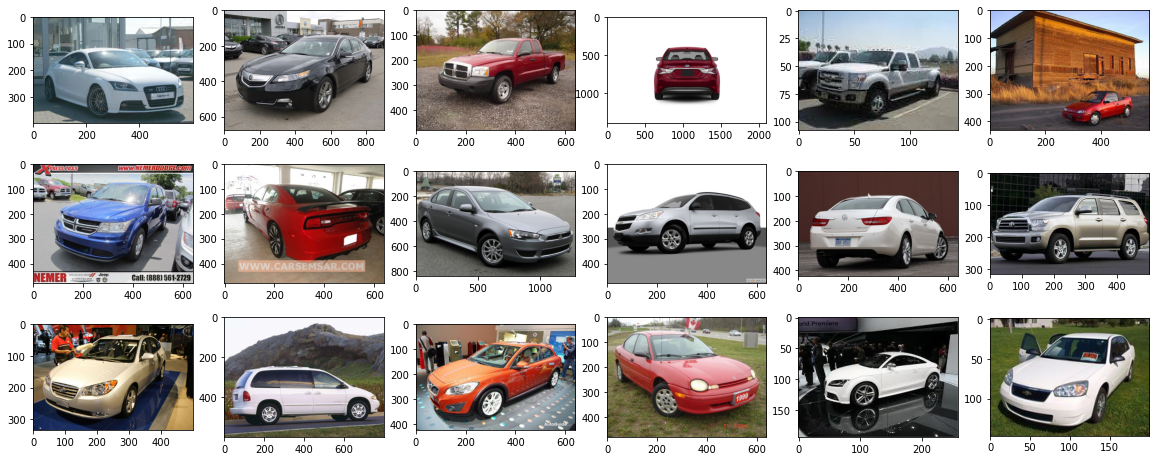

In [ ]:
train_path = '/content/drive/MyDrive/AIML/CapStone/Car Images/Train Images/'
# example train images
plt.figure(figsize=(20,8)) 
for i in range(18):
    plt.subplot(3, 6, i + 1) 
    plt.imshow(plt.imread(train_path + train[ 'filename'][i]))

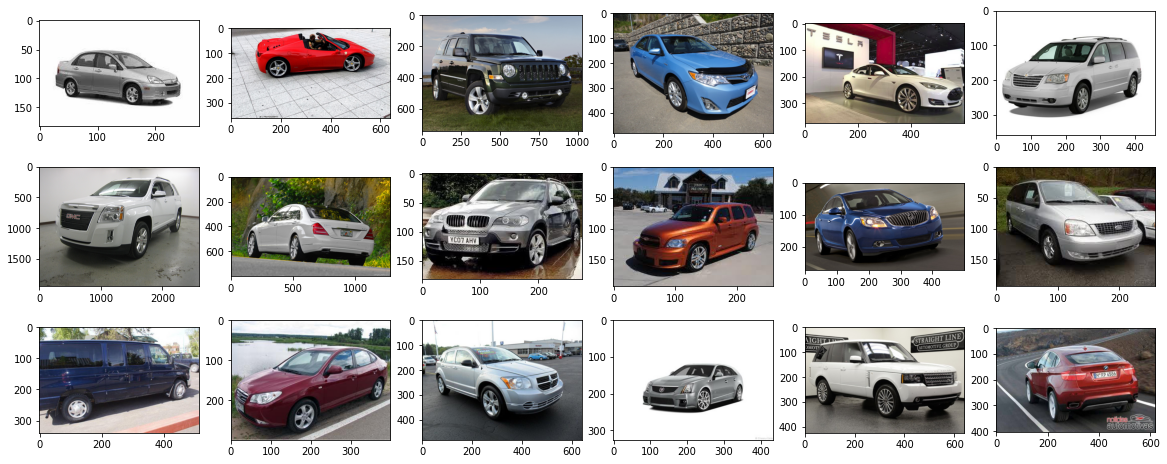

In [ ]:
test_path = '/content/drive/MyDrive/AIML/CapStone/Car Images/Test Images/'
# example test images
plt.figure(figsize=(20,8)) 
for i in range(18):
    plt.subplot(3, 6, i + 1) 
    plt.imshow(plt.imread(test_path + test['filename'][i]))

In [ ]:
#Read the image and draw a rectangle as per bounding box information
import cv2
def display_img_with_BB(path,idx):
    img = cv2.imread(path + train.loc[idx,'filename'])
    cv2.rectangle(img, 
                (train.loc[idx, 'xmin'],train.loc[idx, 'ymin']),
                (train.loc[idx, 'xmax'],train.loc[idx, 'ymax']), 
                (0,255,0),
                2)
    #Convert BGR format (used by opencv to RGB format used by matplotlib)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Draw image using matplotlib
    plt.suptitle(train.loc[img_num, 'class'])
    plt.imshow(img)
    plt.show()

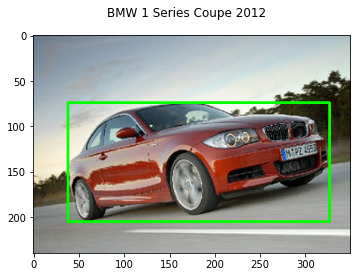

In [ ]:
path = '/content/drive/MyDrive/AIML/CapStone/Car Images/Train Images/'
#Pickup a random image number
img_num = np.random.randint(0, train.shape[0])
display_img_with_BB(path,img_num)

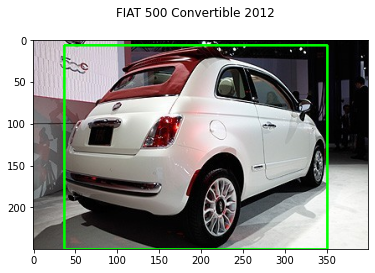

In [ ]:
path = '/content/drive/MyDrive/AIML/CapStone/Car Images/Train Images/'
#Pickup a random image number
img_num = np.random.randint(0, train.shape[0])
display_img_with_BB(path,img_num)

# TFX

In [5]:
PIPELINE_NAME = "car_det_pipeline"
PIPELINE_ROOT = os.path.join(".", "pipeline_output")
INPUT_DATA = os.path.join(".", "input_data")
METADATA_PATH = os.path.join(".", "tfx_metadata", PIPELINE_NAME, "car-det-metadata.db")
ENABLE_CACHE = True
_trainer_module_file = 'trainer.py'
_transform_module_file = 'transform.py'

In [6]:
test = pd.read_csv('/content/drive/MyDrive/AIML/CapStone/test_df_final1.csv')
train = pd.read_csv('/content/drive/MyDrive/AIML/CapStone/train_df_final1.csv')

In [7]:
test.head()

,filepath,filename,imgname,height,width,class,xmin,ymin,xmax,ymax,label
0,/content/drive/MyDrive/AIML/CapStone/Car Image...,Suzuki Aerio Sedan 2007/00001.jpg,00001.jpg,182,276,Suzuki Aerio Sedan 2007,30,52,246,147,181
1,/content/drive/MyDrive/AIML/CapStone/Car Image...,Ferrari 458 Italia Convertible 2012/00002.jpg,00002.jpg,360,640,Ferrari 458 Italia Convertible 2012,100,19,576,203,103
2,/content/drive/MyDrive/AIML/CapStone/Car Image...,Jeep Patriot SUV 2012/00003.jpg,00003.jpg,741,1024,Jeep Patriot SUV 2012,51,105,968,659,145
3,/content/drive/MyDrive/AIML/CapStone/Car Image...,Toyota Camry Sedan 2012/00004.jpg,00004.jpg,480,640,Toyota Camry Sedan 2012,67,84,581,407,187
4,/content/drive/MyDrive/AIML/CapStone/Car Image...,Tesla Model S Sedan 2012/00005.jpg,00005.jpg,373,600,Tesla Model S Sedan 2012,140,151,593,339,185


In [8]:
! cd /content/
! mkdir /content/input_data

In [9]:
train.to_csv("/content/input_data/train_data.csv", index=False,encoding='utf-8')
test.to_csv("/content/input_data/test_data.csv", index=False,encoding='utf-8')

In [10]:
%%writefile {_transform_module_file}
import tensorflow as tf
import tensorflow_transform as tft

@tf.function
def process_image(image):
    img = tf.io.decode_jpeg(image[0], channels=3)
    resized_img = tf.image.resize_with_crop_or_pad(
        img, target_height=512, target_width=512
    )
    resized_img = tf.cast(resized_img, tf.float32)
    # normalize to [-1,1] for
    # https://tfhub.dev/tensorflow/efficientdet/lite3/feature-vector/1
    normalized_img = resized_img / 127.5
    normalized_img = normalized_img - 1.0
    return normalized_img
    # return tf.reshape(normalized_img, [-1, 512, 512, 3])

def _transformed_name(key):
  return key

def preprocessing_fn(tf_record: map) -> map:
    """tf.transform's callback function for preprocessing tf_record.
    Args:
        tf_record: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    """
    _IMAGE_KEY = "filepath"
    _LABEL_KEY = "label"
    _LABEL_NAME = "class"
    _YMIN = "ymin"
    _YMAX = "ymax"
    _XMIN = "xmin"
    _XMAX = "xmax"

    outputs = {}

    # tf.io.decode_jpeg function cannot be applied on a batch of data.
    # We have to use tf.map_fn
    image_features = tf.map_fn(
        lambda image: process_image(image),
        tf_record[_IMAGE_KEY],
        dtype=tf.float32,
    )

    # image_features = tf.keras.applications.mobilenet.preprocess_input(image_features)

    # outputs[_transformed_name(_IMAGE_KEY)] = image_features
    outputs["input_1"] = image_features
    outputs[_transformed_name(_LABEL_KEY)] = tf_record[_LABEL_KEY]
    outputs[_transformed_name(_LABEL_NAME)] = tf_record[_LABEL_NAME]
    outputs[_transformed_name(_YMIN)] = tf_record[_YMIN]
    outputs[_transformed_name(_YMAX)] = tf_record[_YMAX]
    outputs[_transformed_name(_XMIN)] = tf_record[_XMIN]
    outputs[_transformed_name(_XMAX)] = tf_record[_XMAX]

    return outputs

Overwriting transform.py


###**Full Pipeline**

The pipeline can be run on either of the below Orchestrators:
1. Local
2. Airflow
3. Kubeflow

In [11]:
%%writefile {_trainer_module_file}
from typing import List, Text
from absl import logging
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_transform as tft
from tensorflow_transform.tf_metadata import schema_utils

from tfx.components.trainer.executor import TrainerFnArgs
from tfx.components.trainer.fn_args_utils import DataAccessor

# from models import constants
# from models import features
from tfx.utils import io_utils
from tfx_bsl.tfxio import dataset_options

from tensorflow_metadata.proto.v0 import schema_pb2

import tensorflow_hub as hub

# def _get_serve_image_fn(model, tf_transform_output):
#     """Returns a function that feeds the input tensor into the model."""

#     @tf.function
#     def serve_image_fn(serialized_tf_examples):
#         """Returns the output to be used in the serving signature.
#         """

#         feature_spec = tf_transform_output.raw_feature_spec()
#         feature_spec.pop(odp.configs._LABEL_KEY)
#         parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)

#         transformed_features = model.tft_layer(parsed_features)
#         transformed_features[
#             model.get_layer("mobilenet_1.00_224").layers[0].name
#         ] = transformed_features[odp.utils._transformed_name(odp.utils._IMAGE_KEY)]
#         del transformed_features[odp.utils._transformed_name(odp.configs._IMAGE_KEY)]

#         return model(transformed_features)

#     return serve_image_fn


def _input_fn(
    file_pattern: List[Text],
    data_accessor: DataAccessor,
    schema: schema_pb2.Schema,
    batch_size: int = 1,
) -> tf.data.Dataset:
    """Generates features and label for tuning/training.

    Args:
      file_pattern: List of paths or patterns of input tfrecord files.
      data_accessor: DataAccessor for converting input to RecordBatch.
      schema: A schema proto of input data.
      batch_size: representing the number of consecutive elements of returned
        dataset to combine in a single batch

    Returns:
      A dataset that contains (features, indices) tuple where features is a
        dictionary of Tensors, and indices is a single Tensor of label indices.
    """
    return data_accessor.tf_dataset_factory(
        file_pattern,
        dataset_options.TensorFlowDatasetOptions(batch_size=batch_size),
        schema,
    ).repeat()


def _build_keras_model() -> tf.keras.Model:
    """
    Returns:
      A Keras Model.
    """
    do_fine_tuning = False
    IMAGE_SIZE = (512, 512)
    NUM_CLASSES = 3
    # model_handle = "https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1"
    # model_handle = "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1"
    # model_handle = "https://tfhub.dev/tensorflow/efficientdet/d0/1"
    model_handle = "https://tfhub.dev/tensorflow/efficientdet/lite3/feature-vector/1"
    # model = tf.keras.Sequential(
    #     [
    #         # Explicitly define the input shape so the model can be properly
    #         # loaded by the TFLiteConverter
    #         tf.keras.layers.InputLayer(
    #             input_shape=IMAGE_SIZE + (3,), name="image_input"
    #         ),
    #         hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    #         tf.keras.layers.Dropout(rate=0.2),
    #         tf.keras.layers.Dense(
    #             NUM_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    #         ),
    #     ]
    # )

    # model.compile(
    #     optimizer=keras.optimizers.adam(1e-2),
    #     loss=tf.keras.losses.sparsecategoricalcrossentropy(from_logits=true),
    #     metrics=[keras.metrics.sparsecategoricalaccuracy()],
    # )
    img_inputs = keras.Input(shape=IMAGE_SIZE + (3,))
    hub_model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)
    outputs = hub_model(img_inputs)
    model = keras.Model(inputs=img_inputs, outputs=outputs, name="car_det_model")

    model.compile()

    # model.build((None,) + IMAGE_SIZE + (3,))
    model.summary(print_fn=logging.info)
    return model


def run_fn(fn_args: TrainerFnArgs):
    # schema = io_utils.parse_pbtxt_file(fn_args.schema_file, schema_pb2.Schema())
    # feature_list = features.FEATURE_KEYS
    # label_key = features.LABEL_KEY
    # mirrored_strategy = tf.distribute.MirroredStrategy()
    # train_batch_size = (
    #     constants.TRAIN_BATCH_SIZE * mirrored_strategy.num_replicas_in_sync
    # )
    # eval_batch_size = constants.EVAL_BATCH_SIZE * mirrored_strategy.num_replicas_in_sync

    tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

    # Train and eval files contains transformed examples.
    # _input_fn read dataset based on transformed schema from tft.
    train_dataset = _input_fn(
        fn_args.train_files,
        fn_args.data_accessor,
        tf_transform_output.transformed_metadata.schema,
    )
    eval_dataset = _input_fn(
        fn_args.eval_files,
        fn_args.data_accessor,
        tf_transform_output.transformed_metadata.schema,
    )

    # with mirrored_strategy.scope():
    model = _build_keras_model()

    # Write logs to path
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=fn_args.model_run_dir, update_freq="batch"
    )

    model.fit(
        train_dataset,
        steps_per_epoch=fn_args.train_steps,
        validation_data=eval_dataset,
        validation_steps=fn_args.eval_steps,
        callbacks=[tensorboard_callback],
    )

    # signatures = {
    #     "serving_default": _get_serve_image_fn(model).get_concrete_function(
    #         tf.TensorSpec(
    #             shape=[None, 512, 512, 3],
    #             dtype=tf.float32,
    #             name="image/encoded_xf",
    #         )
    #     )
    # }

    # signatures = {
    #     "serving_default": _get_serve_tf_examples_fn(
    #         model, schema, tf_transform_output
    #     ).get_concrete_function(
    #         tf.TensorSpec(shape=[None], dtype=tf.string, name="examples")
    #     ),
    # }

    model.save(fn_args.serving_model_dir, save_format="tf")

Overwriting trainer.py


In [12]:
def create_pipeline(
    pipeline_name: Text,
    pipeline_root: Text,
    data_path: Text,
    metadata_connection_config: Optional[metadata_store_pb2.ConnectionConfig] = None,
    beam_pipeline_args: Optional[List[Text]] = None,
):
    components = []

    output = example_gen_pb2.Output(
        split_config=example_gen_pb2.SplitConfig(
            splits=[
                example_gen_pb2.SplitConfig.Split(name="train", hash_buckets=3),
                example_gen_pb2.SplitConfig.Split(name="eval", hash_buckets=1),
            ]
        )
    )

    example_gen = CsvExampleGen(input_base=data_path, output_config=output)
    components.append(example_gen)

    # Computes statistics over data for visualization and example validation.
    statistics_gen = StatisticsGen(
        examples=example_gen.outputs["examples"],
        exclude_splits=["eval"],
    )
    components.append(statistics_gen)

    # Generates schema based on statistics files.
    schema_gen = SchemaGen(
        statistics=statistics_gen.outputs["statistics"],
        exclude_splits=["eval"],
        infer_feature_shape=True,
    )
    components.append(schema_gen)

    # Performs anomaly detection based on statistics and data schema.
    example_validator = ExampleValidator(  # pylint: disable=unused-variable
        statistics=statistics_gen.outputs["statistics"],
        schema=schema_gen.outputs["schema"],
        exclude_splits=["eval"],
    )
    components.append(example_validator)

    transform = Transform(
        examples=example_gen.outputs["examples"],
        schema=schema_gen.outputs["schema"],
        module_file=os.path.abspath(_transform_module_file),
    )
    components.append(transform)

    # Uses user-provided Python function that
    # implements a model using Tensorflow.
    trainer = Trainer(
        module_file=os.path.abspath(_trainer_module_file),
        # examples=example_gen.outputs["examples"],
        # Use outputs of Transform as training inputs if Transform is used.
        examples=transform.outputs["transformed_examples"],
        transform_graph=transform.outputs["transform_graph"],
        schema=schema_gen.outputs["schema"],
        train_args=trainer_pb2.TrainArgs(),
        eval_args=trainer_pb2.EvalArgs(),
        custom_executor_spec=executor_spec.ExecutorClassSpec(
            trainer_executor.GenericExecutor
        ),
    )
    components.append(trainer)

    return pipeline.Pipeline(
        pipeline_name=pipeline_name,
        pipeline_root=pipeline_root,
        components=components,
        enable_cache=True,
        metadata_connection_config=metadata_connection_config,
        beam_pipeline_args=beam_pipeline_args,
    )


def run_pipeline():
    pipeline = create_pipeline(
        pipeline_name=PIPELINE_NAME,
        pipeline_root=PIPELINE_ROOT,
        data_path='/content/input_data',
        metadata_connection_config=metadata.sqlite_metadata_connection_config(
            METADATA_PATH
        ),
    )

    LocalDagRunner().run(pipeline)


if __name__ == "__main__":
    logging.set_verbosity(logging.INFO)
    run_pipeline()

INFO:absl:Generating ephemeral wheel package for '/content/drive/My Drive/AIML/CapStone/transform.py' (including modules: ['model_main_tf2', 'train', 'trainer', 'transform']).
INFO:absl:User module package has hash fingerprint version 7465c282b1bdaf447ac2218e4bde09dcdb7db06cc8a39ebefdcf0420ccbbbf4e.
INFO:absl:Executing: ['/usr/bin/python3', '/tmp/tmpaesfndtd/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmpcfmes8vh', '--dist-dir', '/tmp/tmpfzjzckqe']
INFO:absl:Successfully built user code wheel distribution at './pipeline_output/_wheels/tfx_user_code_Transform-0.0+7465c282b1bdaf447ac2218e4bde09dcdb7db06cc8a39ebefdcf0420ccbbbf4e-py3-none-any.whl'; target user module is 'transform'.
INFO:absl:Full user module path is 'transform@./pipeline_output/_wheels/tfx_user_code_Transform-0.0+7465c282b1bdaf447ac2218e4bde09dcdb7db06cc8a39ebefdcf0420ccbbbf4e-py3-none-any.whl'
INFO:absl:Generating ephemeral wheel package for '/content/drive/My Drive/AIML/CapStone/trainer.py' (including 

INFO:absl:Processing input csv data /content/input_data/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 17 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'examples': [Artifact(artifact: uri: "./pipeline_output/CsvExampleGen/examples/17"
custom_properties {
  key: "input_fingerprint"
  value {
    string_value: "split:single_split,num_files:2,total_bytes:3235322,xor_checksum:0,sum_checksum:3283421636"
  }
}
custom_properties {
  key: "name"
  value {
    string_value: "car_det_pipeline:2022-01-09T06:48:24.940178:CsvExampleGen:examples:0"
  }
}
custom_properties {
  key: "span"
  value {
    int_value: 0
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.5.0"
  }
}
, artifact_type: name: "Examples"
properties {
  key: "span"
  value: INT
}
properties {
  key: "split_names"
  value: STRING
}
properties {
  key: "version"

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.
INFO:absl:Feature class has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature filename has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature filepath has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature height has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature imgname has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature label has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature width has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature xmax has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature xmin has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature ymax has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature ymin has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature class has a shape dim {
  size: 1
}
. Setting to De

INFO:tensorflow:Assets written to: ./pipeline_output/Transform/transform_graph/21/.temp_path/tftransform_tmp/a036c296181144c386b810a4c66735ec/assets


INFO:tensorflow:Assets written to: ./pipeline_output/Transform/transform_graph/21/.temp_path/tftransform_tmp/a036c296181144c386b810a4c66735ec/assets


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.
INFO:absl:MetadataStore with DB connection initialized
ERROR:absl:Execution 21 failed.
INFO:absl:Cleaning up stateless execution info.


ValueError: ignored